In [1]:
import os
from utils.configuration import *
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

In [2]:
experiment_name = "api_ordinal_wine_example"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

In [3]:
setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists/home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/configuration.json


In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine

wine = load_wine()
df = pd.DataFrame(wine['data'], columns=wine['feature_names'])
df['target'] = wine['target']

# simulate 1000 samples using Gaussian noise proportional to feature std
X = df.drop(columns='target').values
y = df['target'].values

n_new = 1000 - len(df)
noise_scale = 0.05  # adjust for realism
X_new = []

for _ in range(n_new):
    i = np.random.randint(0, len(X))
    sample = X[i] + np.random.normal(0, noise_scale * X.std(axis=0), X.shape[1])
    X_new.append(sample)

X_new = np.vstack(X_new)
y_new = np.random.choice(y, size=n_new, replace=True)

df_new = pd.DataFrame(X_new, columns=wine['feature_names'])
df_new['target'] = y_new

df_simulated = pd.concat([df, df_new], ignore_index=True)
print(df_simulated.shape)
df_simulated.head()
df=df_simulated

(1000, 14)


In [5]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [6]:
train_df.to_csv(os.path.join(EXPERIMENT_DIR,"train.csv"), index=False)
val_df.to_csv(os.path.join(EXPERIMENT_DIR,"val.csv"), index=False)
test_df.to_csv(os.path.join(EXPERIMENT_DIR,"test.csv"), index=False)

In [7]:
data_type={key:value for key, value in zip(train_df.columns, ['continous']*13+['ordinal_Xc_Yo'])}
data_type

{'alcohol': 'continous',
 'malic_acid': 'continous',
 'ash': 'continous',
 'alcalinity_of_ash': 'continous',
 'magnesium': 'continous',
 'total_phenols': 'continous',
 'flavanoids': 'continous',
 'nonflavanoid_phenols': 'continous',
 'proanthocyanins': 'continous',
 'color_intensity': 'continous',
 'hue': 'continous',
 'od280/od315_of_diluted_wines': 'continous',
 'proline': 'continous',
 'target': 'ordinal_Xc_Yo'}

In [8]:
write_data_type_to_configuration(data_type, CONF_DICT_PATH)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
alcohol              | continous       | continuous [c]                 | continuous [c]                
malic_acid           | continous       | continuous [c]                 | continuous [c]                
ash                  | continous       | continuous [c]                 | continuous [c]                
alcalinity_of_ash    | continous       | continuous [c]                 | continuous [c]                
magnesium            | continous       | continuous [c]                 | continuous [c]                
total_phenols        | continous       | continuous [c]  

/home/bule/TramDag/utils/configuration.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


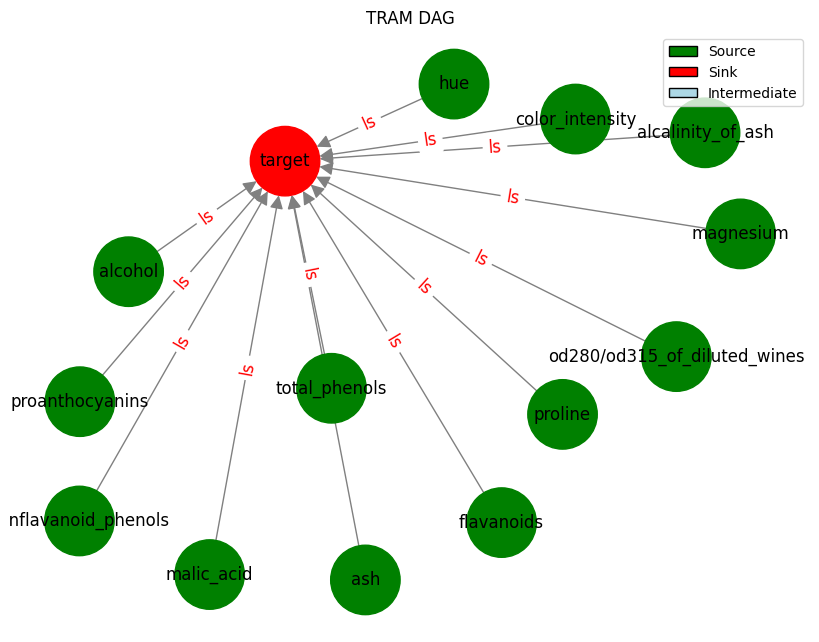

In [9]:
interactive_adj_matrix(CONF_DICT_PATH,seed=19)

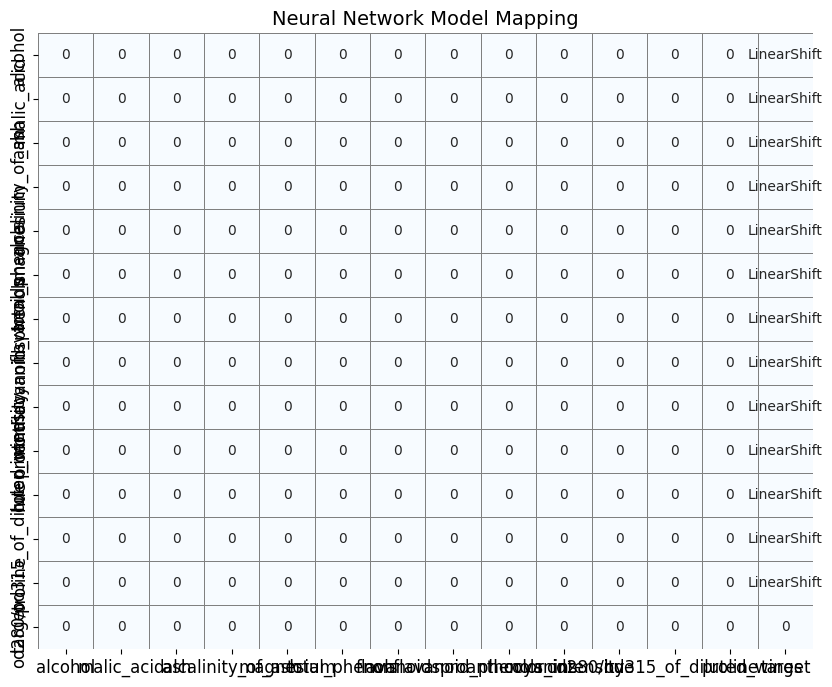

In [10]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [11]:
from utils.tramdag import TramDagConfig , TramDagModel

cfg = TramDagConfig.load("/home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/configuration.json")
cfg.compute_levels(train_df)
device='cpu'

In [12]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=True,device=device,initial_data = train_df)#) 
# 1m52s

[DEBUG] TramDagModel using device: cpu

[INFO] Building model for node 'alcohol' with settings: {'set_initial_weights': False, 'debug': True, 'verbose': True, 'device': 'cpu', 'initial_data':        alcohol  malic_acid       ash  alcalinity_of_ash   magnesium  \
29   14.020000    1.680000  2.210000          16.000000   96.000000   
535  13.820443    1.922421  2.598538          15.088922  100.879901   
695  12.287052    4.643467  2.536173          21.117109   90.341955   
557  14.245508    2.461667  2.488626          20.319947   91.411399   
836  12.887291    1.545626  2.509810          17.850231   96.125431   
..         ...         ...       ...                ...         ...   
106  12.250000    1.730000  2.120000          19.000000   80.000000   
270  12.889985    2.307750  2.404126          24.045778   98.894529   
860  14.158941    1.702533  2.449896          15.082149  113.695830   
435  12.280962    2.403755  2.455795          21.063898   96.627726   
102  12.340000    2.450000 

In [13]:
td_model.fit(train_df, val_df,
            #  train_list=['target'],
             learning_rate=1e-2,
             epochs=30,batch_size=10,
             save_linear_shifts=True,
             verbose=True,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

#30 eps 1m 49s seq mode from start 1000 bs
#30 eps 2m 27s parllel multiprocessing mode from start 1000 bs
# 200 eps 9m 30s seq mode from start 1000 bs

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/min_max_scaling.json
[INFO] Training 14 nodes (sequential) on cpu

[INFO] Training node 'alcohol' for 30 epochs on cpu (pid=455834)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'malic_acid' for 30 epochs on cpu (pid=455834)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'ash' for 30 epochs on cpu (pid=455834)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'alcalinity_of_ash' for 30 epochs on cpu (pid=455834)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'magnesium' for 30 epochs on cpu (pid=455834)
[INFO] Existing model found. Loading weights and history from LAST model...

[INFO] Training node 'total_phenols' for 30 epochs on cpu (pi

In [14]:
rsamples, latents = td_model.sample(use_initial_weights_for_sampling=True)

[INFO] Starting full DAG sampling with 10000 samples per node.
[INFO] Deleting all previously sampled data.
Deleted directory: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/alcohol/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/malic_acid/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/ash/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/alcalinity_of_ash/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/magnesium/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/total_phenols/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/flavanoids/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/nonflavanoid_phenols/sampling
Deleted directory: /home/bule/TramDag/dev_experiment_logs/a

[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 40.05it/s]

[INFO] Completed sampling for node 'alcohol'

----*----------*-------------*--------Sample Node: malic_acid ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node malic_acid from standard logistic distribution
[INFO] Using initial weights for sampling for node 'malic_acid'
[WARNING] target_col 'malic_acid' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 44.36it/s]

[INFO] Completed sampling for node 'malic_acid'

----*----------*-------------*--------Sample Node: ash ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node ash from standard logistic distribution
[INFO] Using initial weights for sampling for node 'ash'
[WARNING] target_col 'ash' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 41.02it/s]

[INFO] Completed sampling for node 'ash'

----*----------*-------------*--------Sample Node: alcalinity_of_ash ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node alcalinity_of_ash from standard logistic distribution
[INFO] Using initial weights for sampling for node 'alcalinity_of_ash'
[WARNING] target_col 'alcalinity_of_ash' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 42.41it/s]

[INFO] Completed sampling for node 'alcalinity_of_ash'

----*----------*-------------*--------Sample Node: magnesium ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node magnesium from standard logistic distribution
[INFO] Using initial weights for sampling for node 'magnesium'
[WARNING] target_col 'magnesium' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 41.48it/s]

[INFO] Completed sampling for node 'magnesium'

----*----------*-------------*--------Sample Node: total_phenols ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node total_phenols from standard logistic distribution
[INFO] Using initial weights for sampling for node 'total_phenols'
[WARNING] target_col 'total_phenols' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 41.49it/s]

[INFO] Completed sampling for node 'total_phenols'

----*----------*-------------*--------Sample Node: flavanoids ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node flavanoids from standard logistic distribution
[INFO] Using initial weights for sampling for node 'flavanoids'
[WARNING] target_col 'flavanoids' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 42.27it/s]

[INFO] Completed sampling for node 'flavanoids'

----*----------*-------------*--------Sample Node: nonflavanoid_phenols ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node nonflavanoid_phenols from standard logistic distribution
[INFO] Using initial weights for sampling for node 'nonflavanoid_phenols'
[WARNING] target_col 'nonflavanoid_phenols' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 42.42it/s]

[INFO] Completed sampling for node 'nonflavanoid_phenols'

----*----------*-------------*--------Sample Node: proanthocyanins ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node proanthocyanins from standard logistic distribution
[INFO] Using initial weights for sampling for node 'proanthocyanins'
[WARNING] target_col 'proanthocyanins' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 40.07it/s]

[INFO] Completed sampling for node 'proanthocyanins'

----*----------*-------------*--------Sample Node: color_intensity ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node color_intensity from standard logistic distribution
[INFO] Using initial weights for sampling for node 'color_intensity'
[WARNING] target_col 'color_intensity' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 43.09it/s]

[INFO] Completed sampling for node 'color_intensity'

----*----------*-------------*--------Sample Node: hue ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node hue from standard logistic distribution
[INFO] Using initial weights for sampling for node 'hue'
[WARNING] target_col 'hue' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 39.87it/s]

[INFO] Completed sampling for node 'hue'

----*----------*-------------*--------Sample Node: od280/od315_of_diluted_wines ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node od280/od315_of_diluted_wines from standard logistic distribution
[INFO] Using initial weights for sampling for node 'od280/od315_of_diluted_wines'
[WARNING] target_col 'od280/od315_of_diluted_wines' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 41.94it/s]

[INFO] Completed sampling for node 'od280/od315_of_diluted_wines'

----*----------*-------------*--------Sample Node: proline ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node proline from standard logistic distribution
[INFO] Using initial weights for sampling for node 'proline'
[WARNING] target_col 'proline' not in DataFrame columns — is this intended to be used as a Sampler?



[INFO] Chandrupatla root finding ->  iterations:: 100%|██████████| 100/100 [00:02<00:00, 44.40it/s]

[INFO] Completed sampling for node 'proline'

----*----------*-------------*--------Sample Node: target ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node target from standard logistic distribution
[INFO] Using initial weights for sampling for node 'target'
[WARNING] target_col 'target' not in DataFrame columns — is this intended to be used as a Sampler?


[INFO] Completed sampling for node 'target'
[INFO] DAG sampling completed successfully for all nodes.


[INFO] Loaded training/validation histories for 14 nodes.


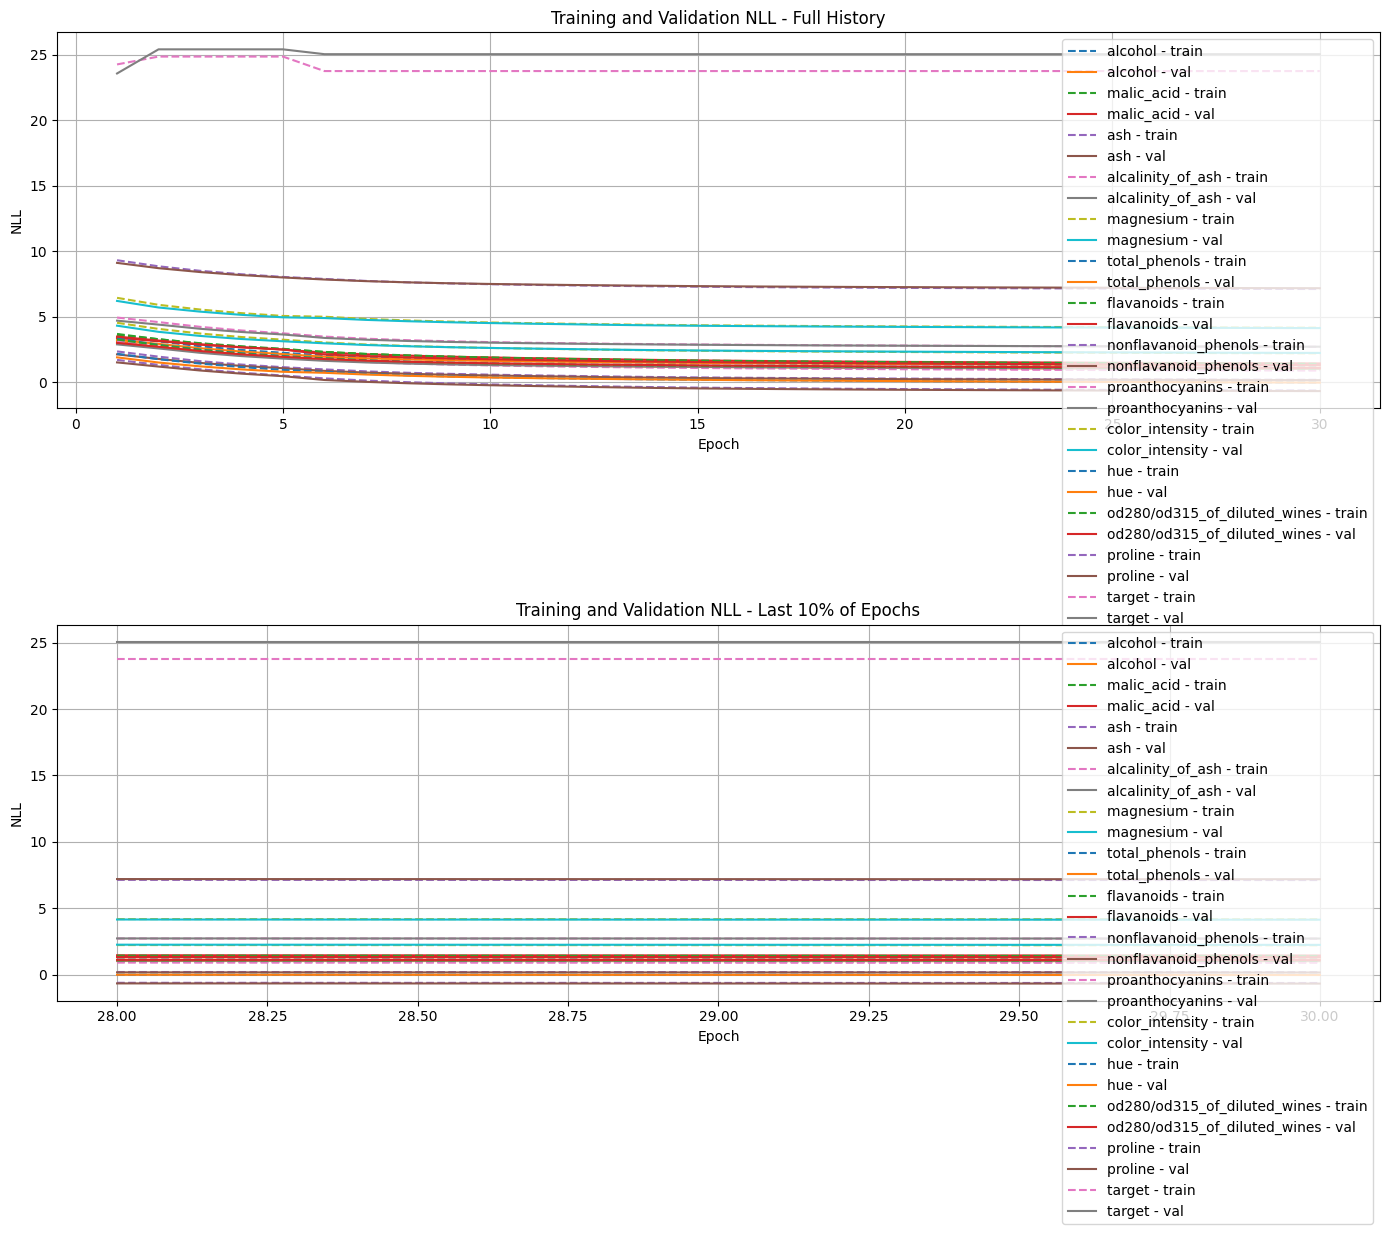

In [15]:
td_model.plot_loss_history()

[WARNING] No linear shift history found for node 'alcohol' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/alcohol/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'malic_acid' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/malic_acid/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'ash' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/ash/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'alcalinity_of_ash' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/alcalinity_of_ash/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'magnesium' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/magnesium/linear_shifts_all_epochs.json
[WARNING] No linear shift history found for node 'total_phenols' at /home/bule/TramDag/dev_experiment_logs/api_ordinal_wine_example/total_phenols/linear_shift

/home/bule/TramDag/utils/tramdag.py:1507: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


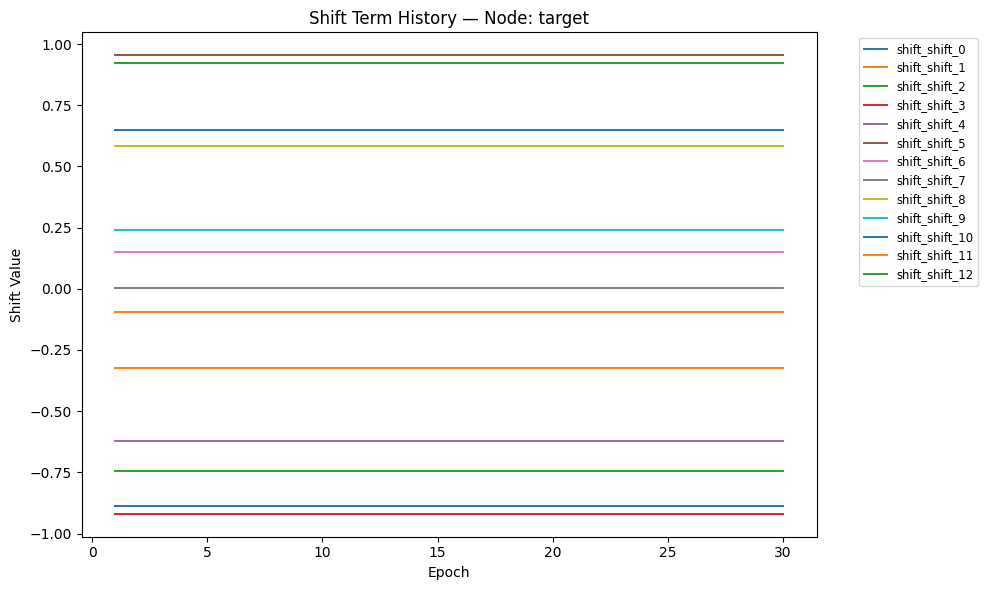

In [18]:
td_model.plot_linear_shift_history()#ref_lines={'x2': [2],'x3': [-0.2]})


/home/bule/TramDag/utils/tramdag.py:1564: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(extract_scalar)


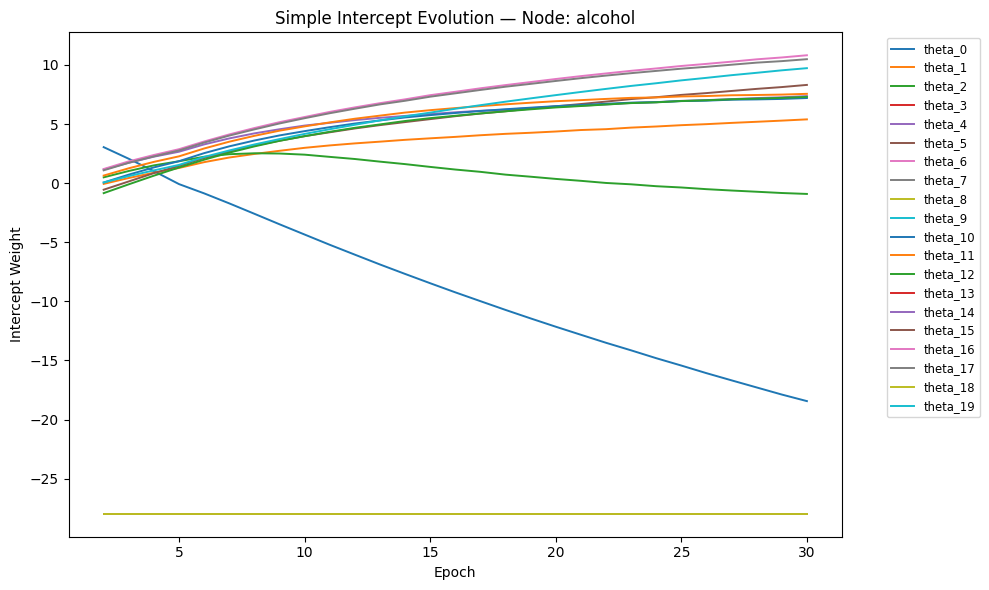

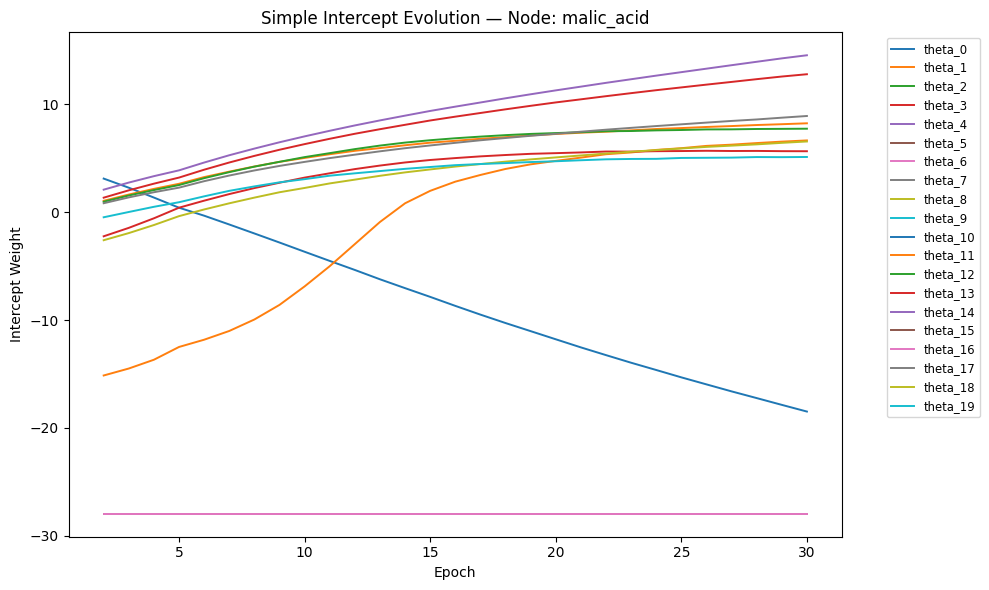

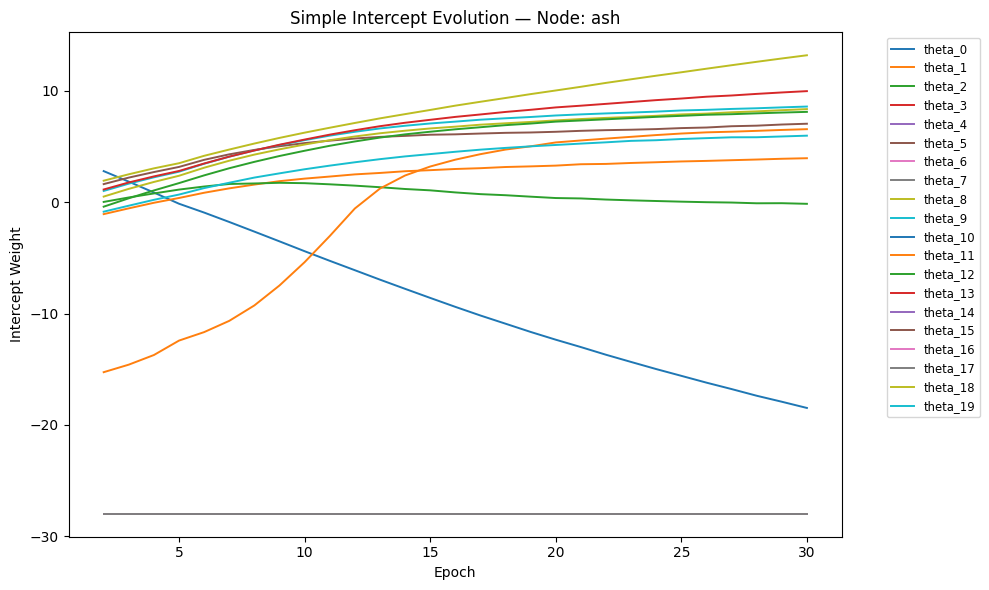

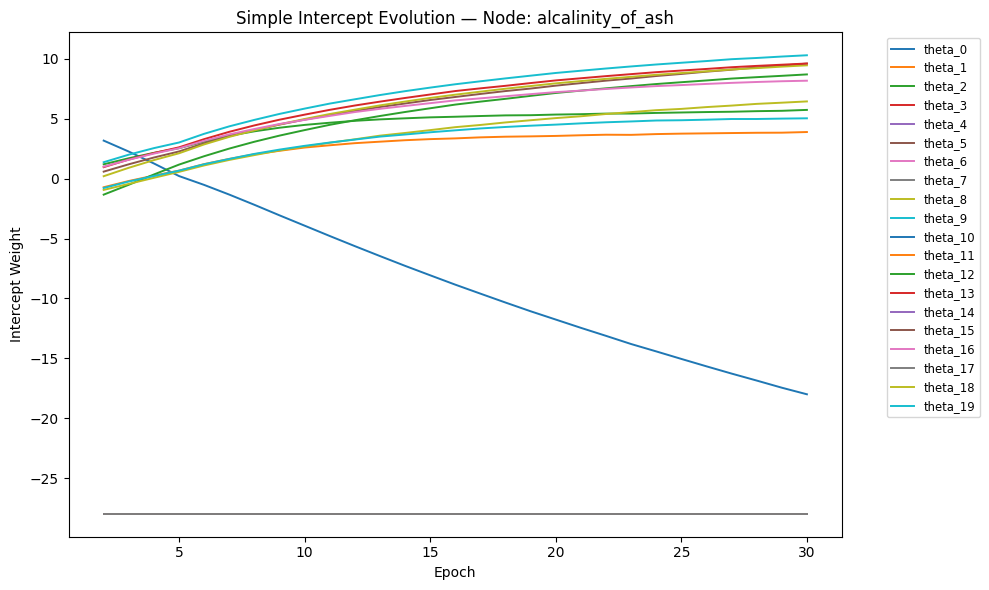

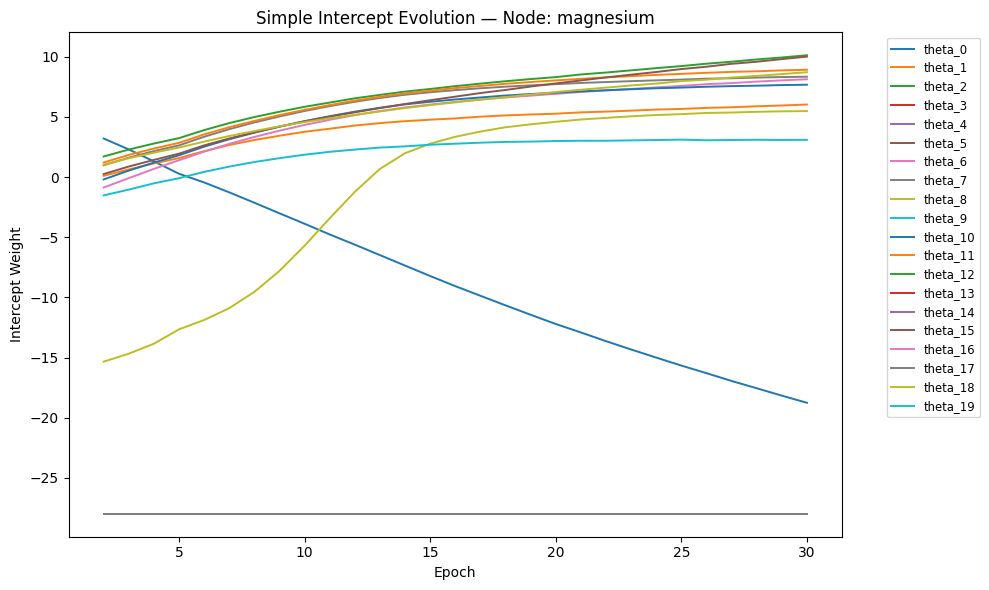

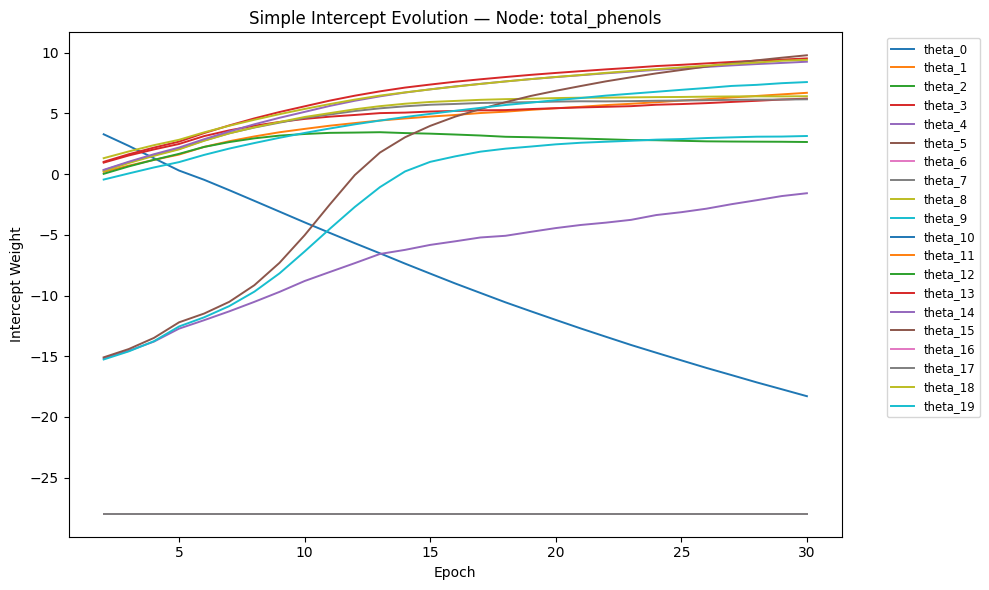

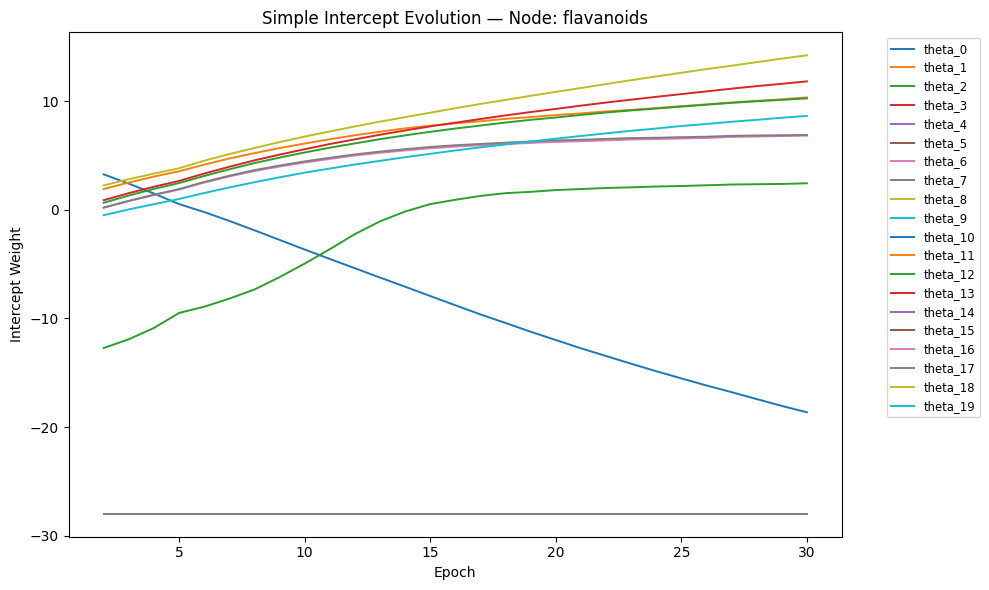

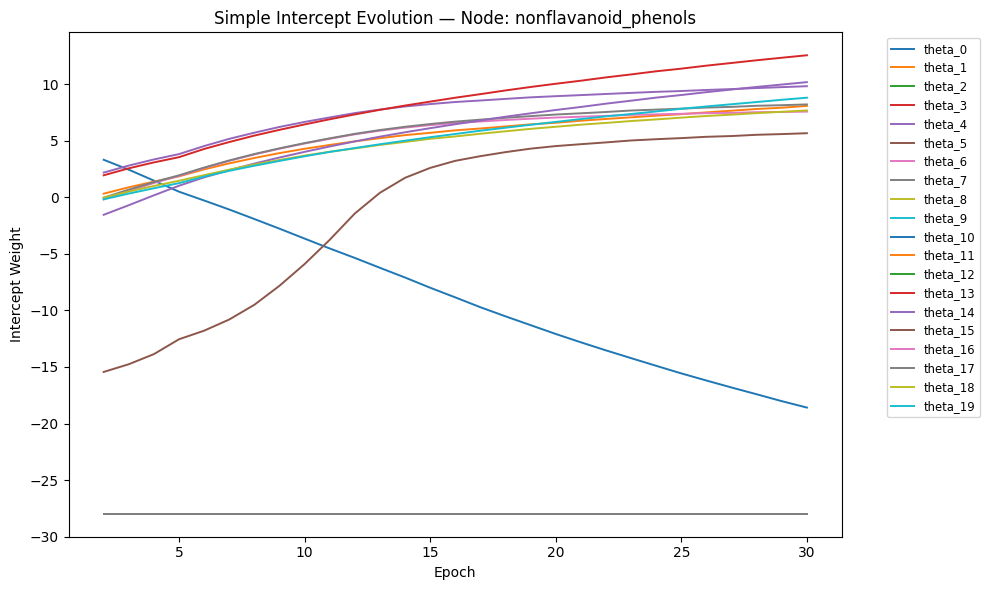

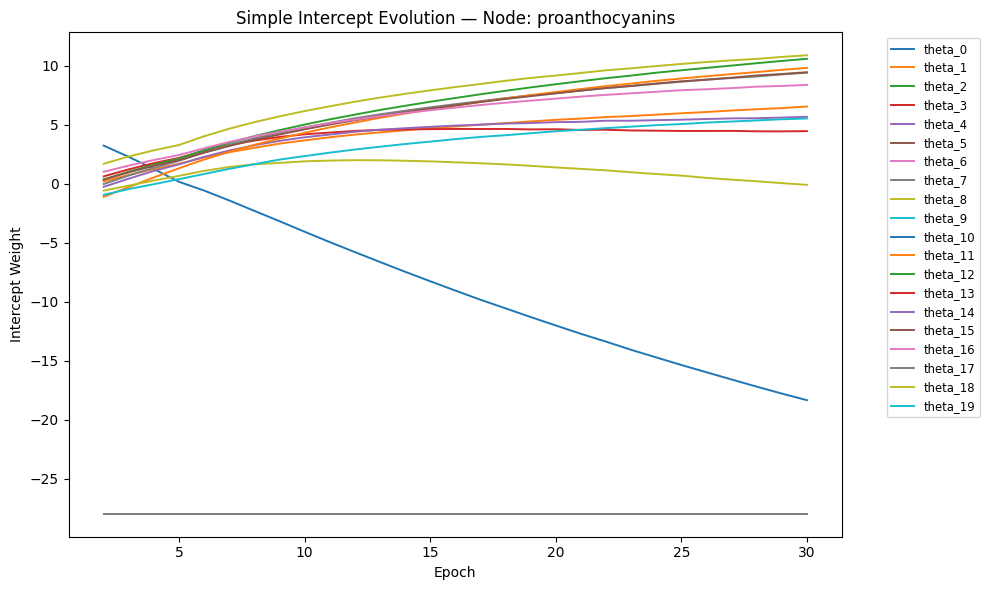

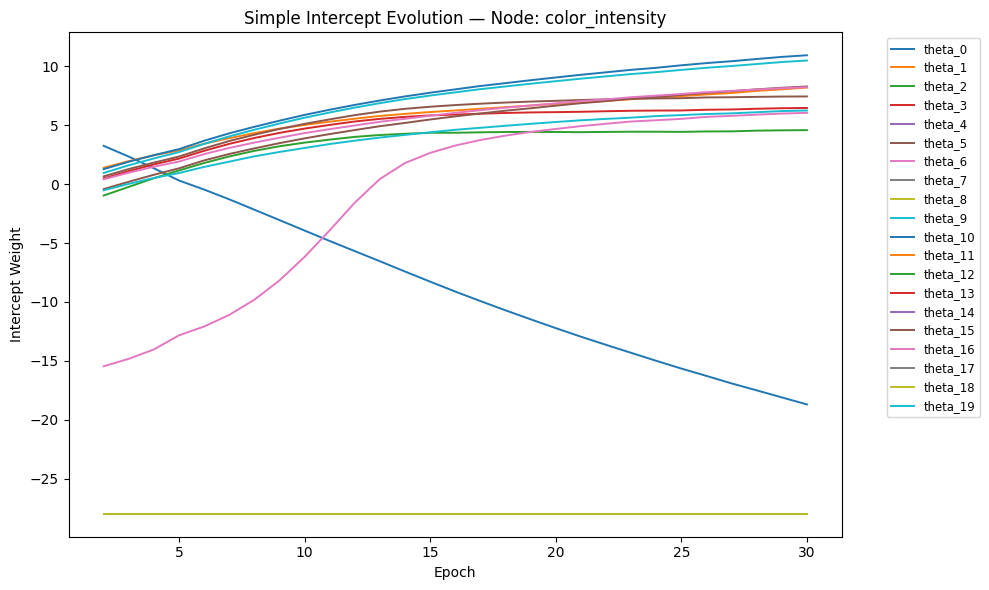

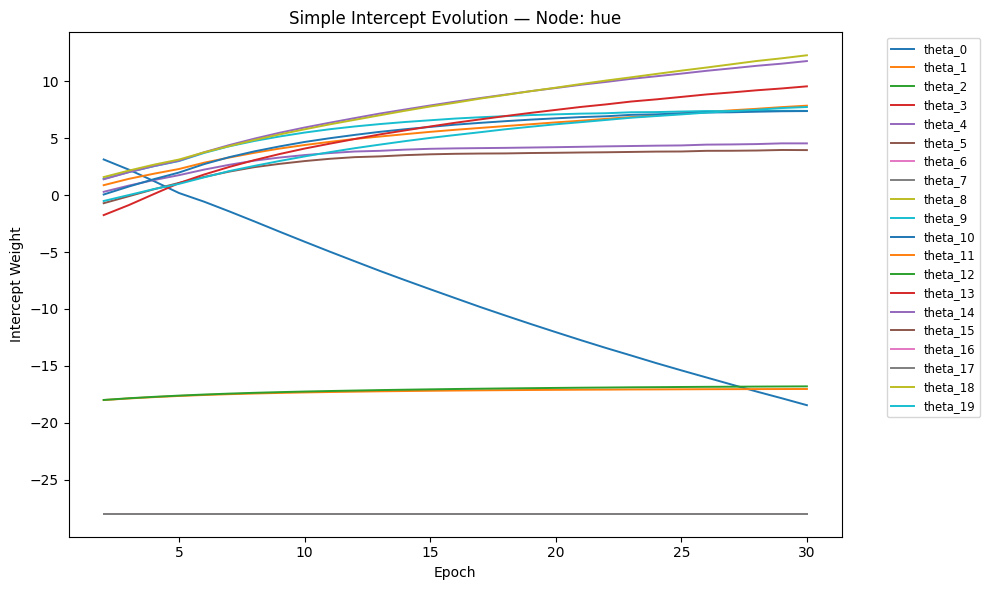

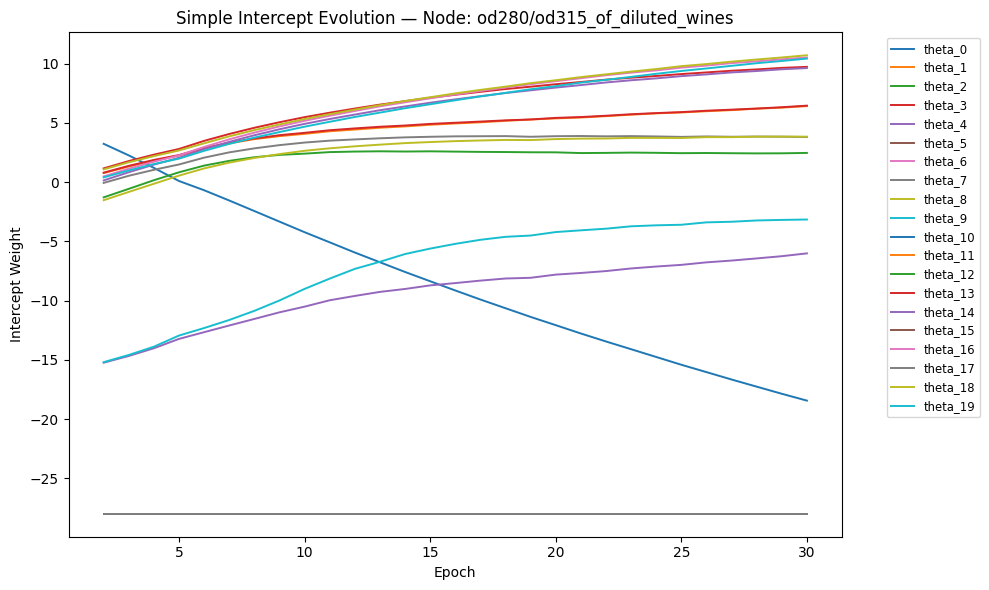

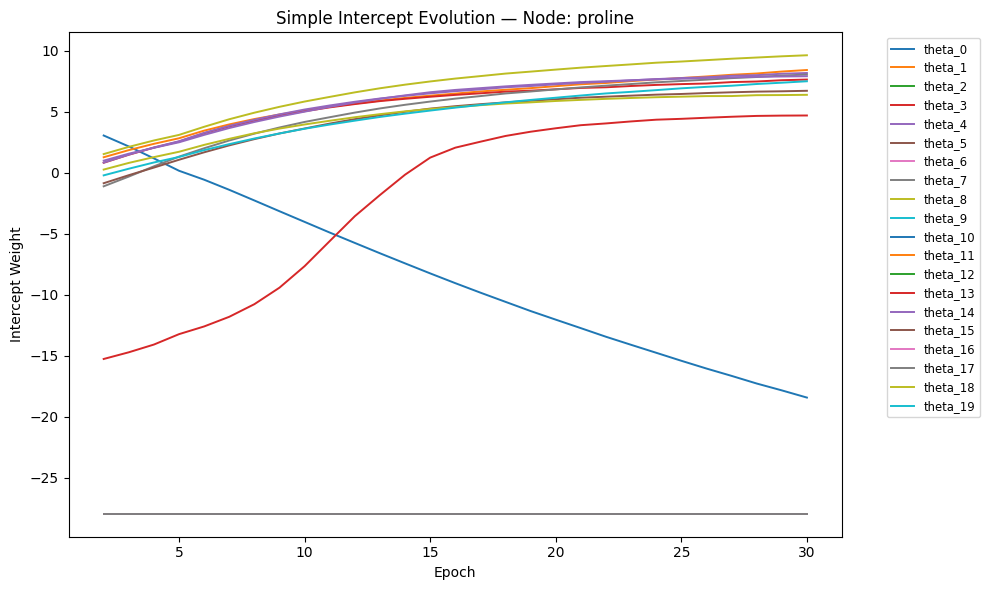

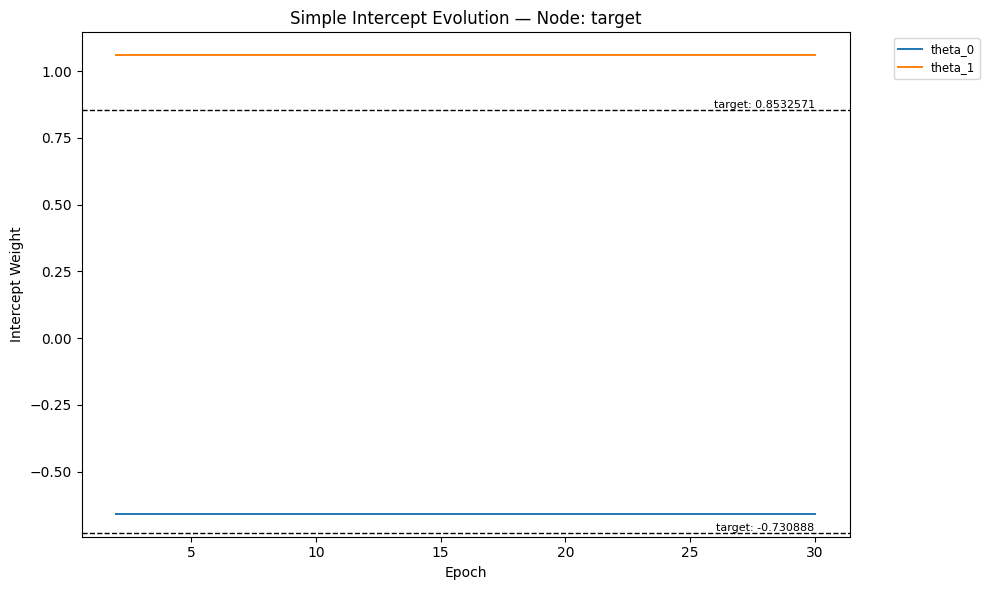

In [20]:
td_model.plot_simple_intercepts_history(ref_lines={'target':[-0.730888 ,  0.8532571]})

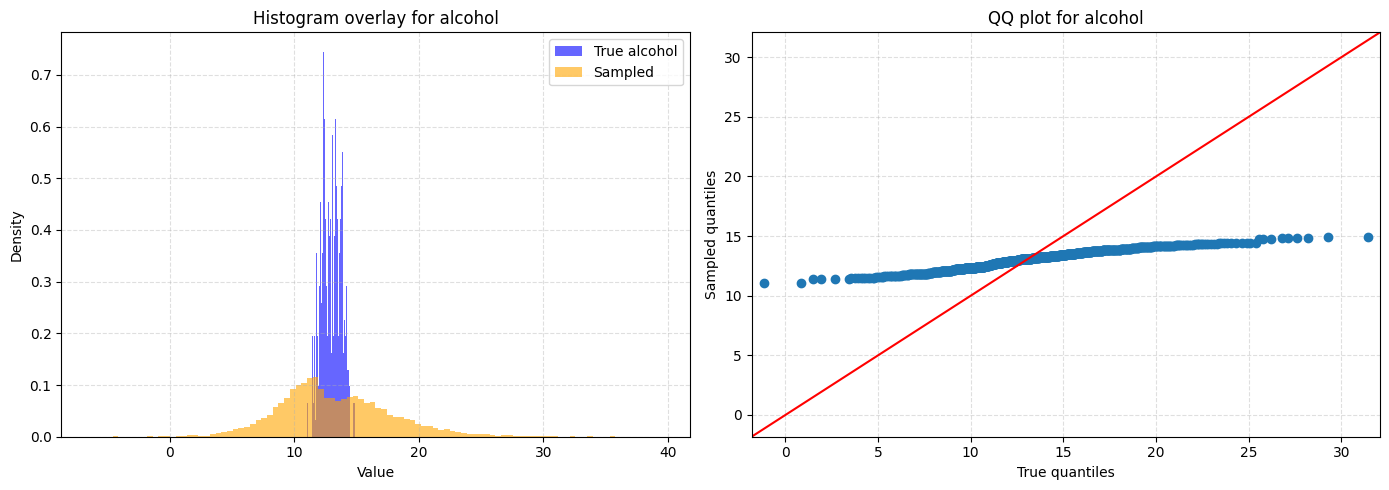

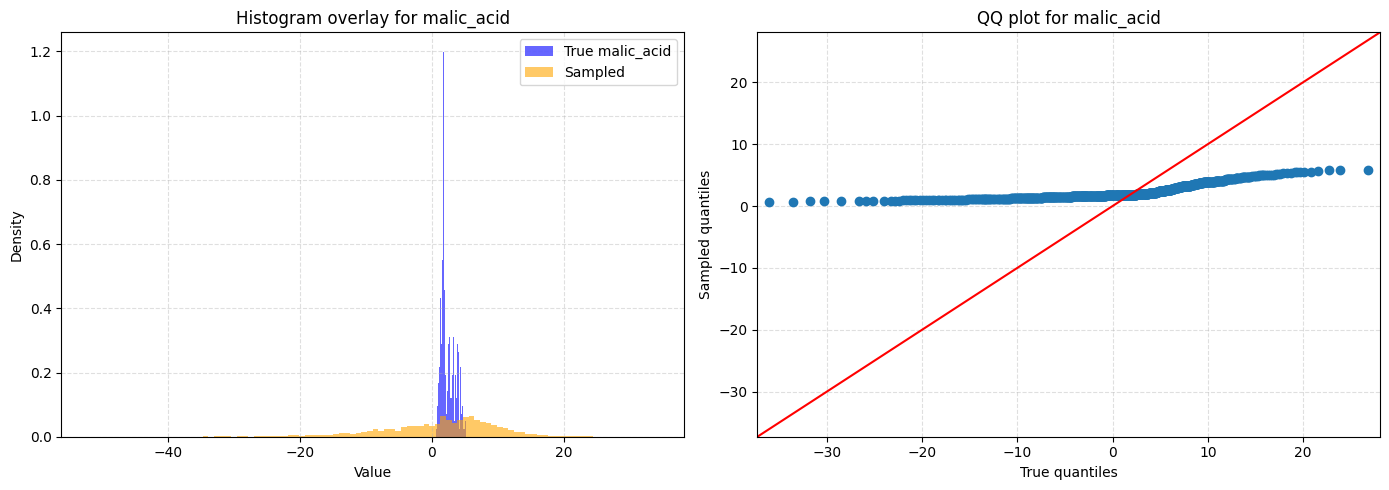

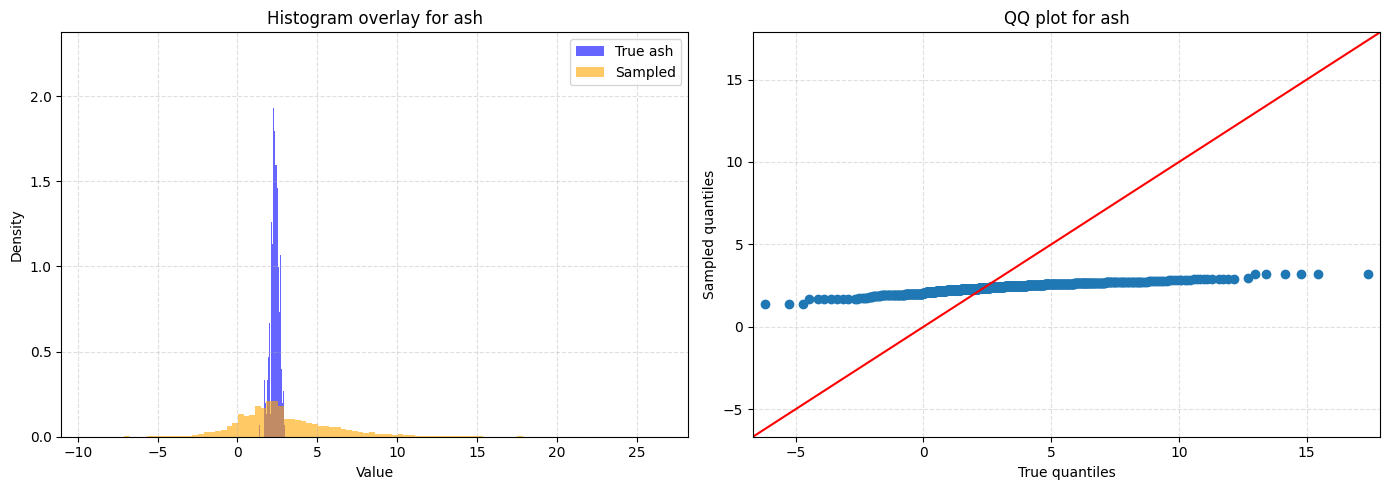

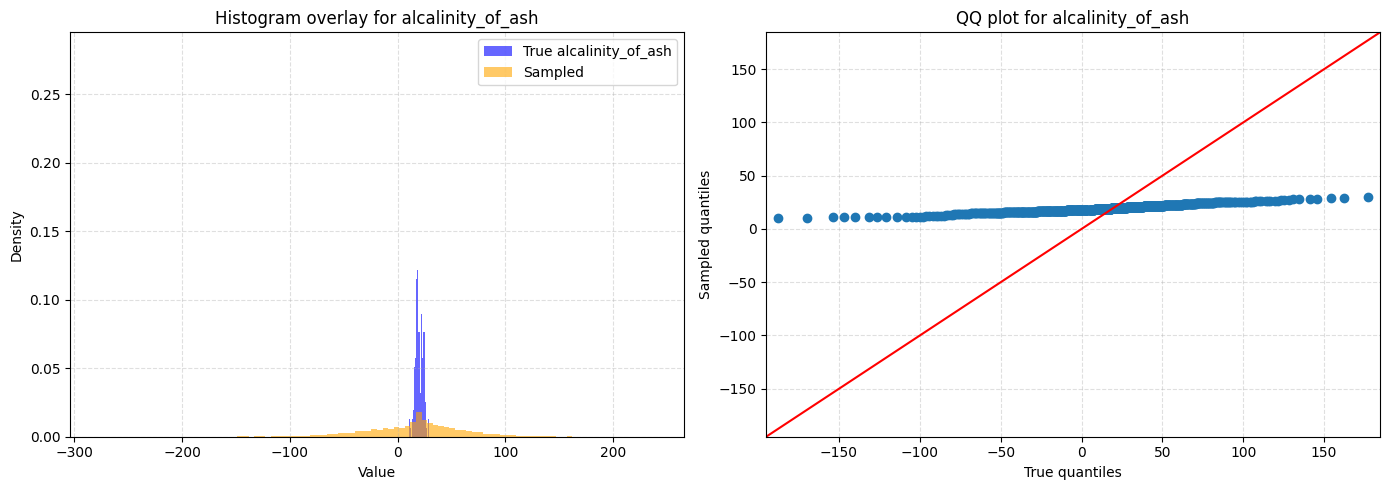

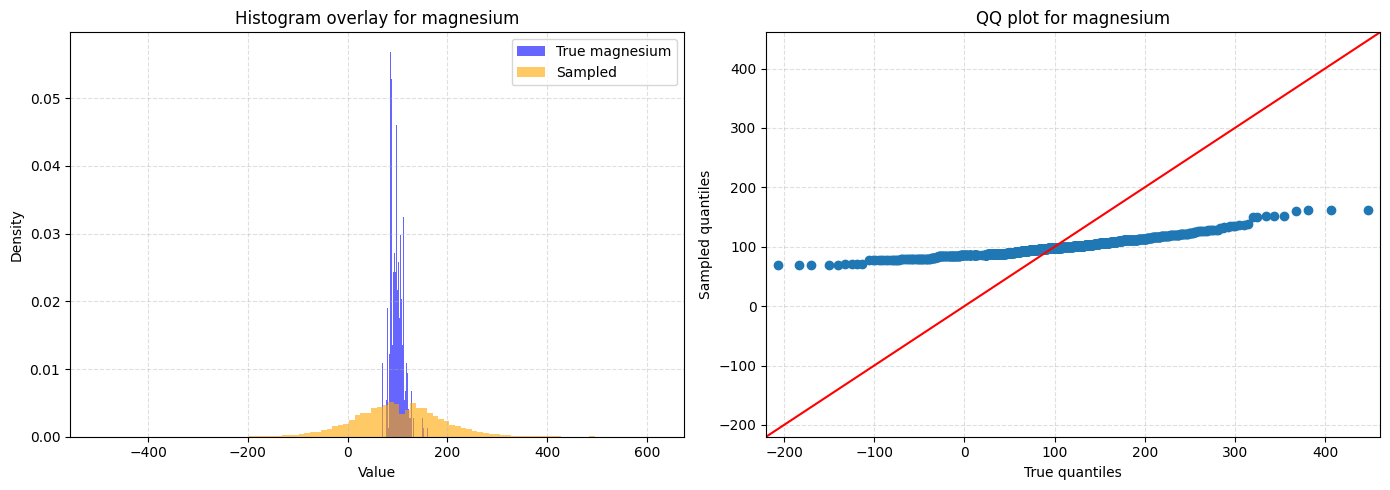

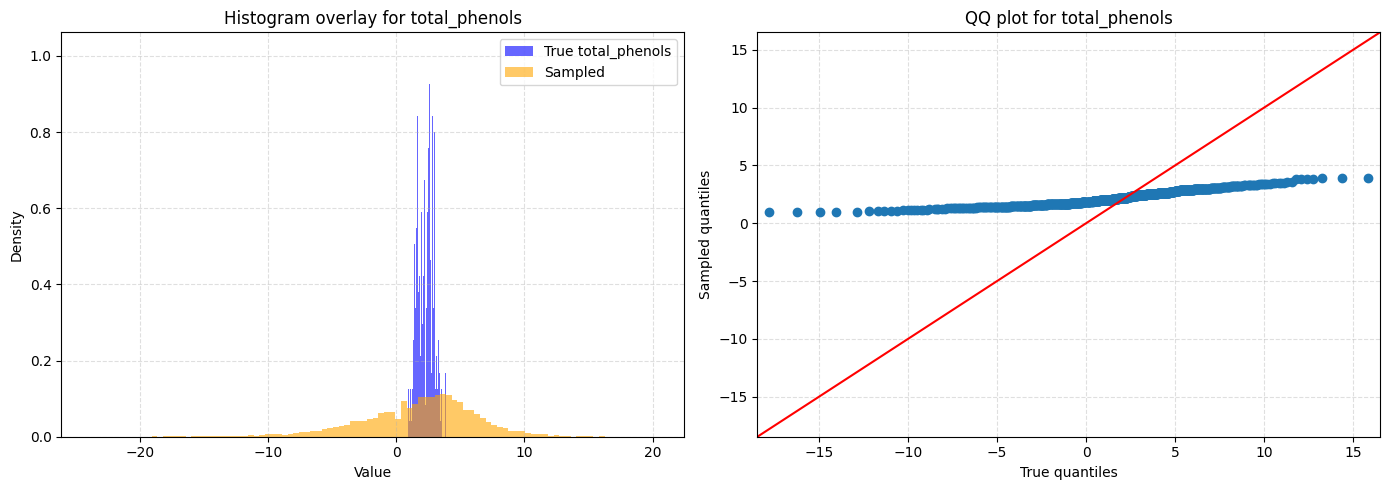

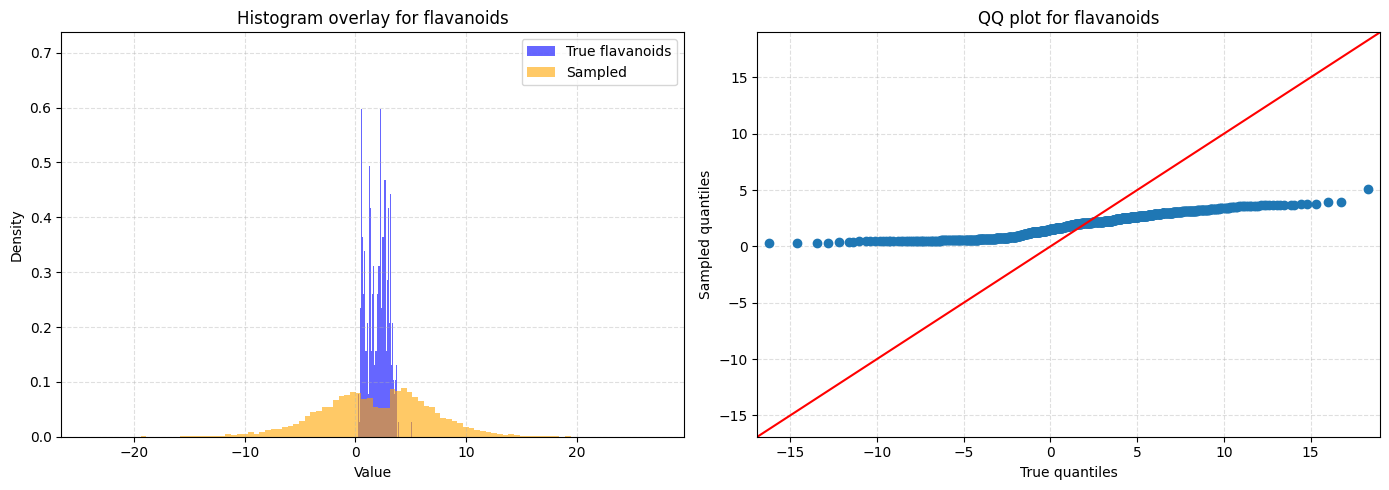

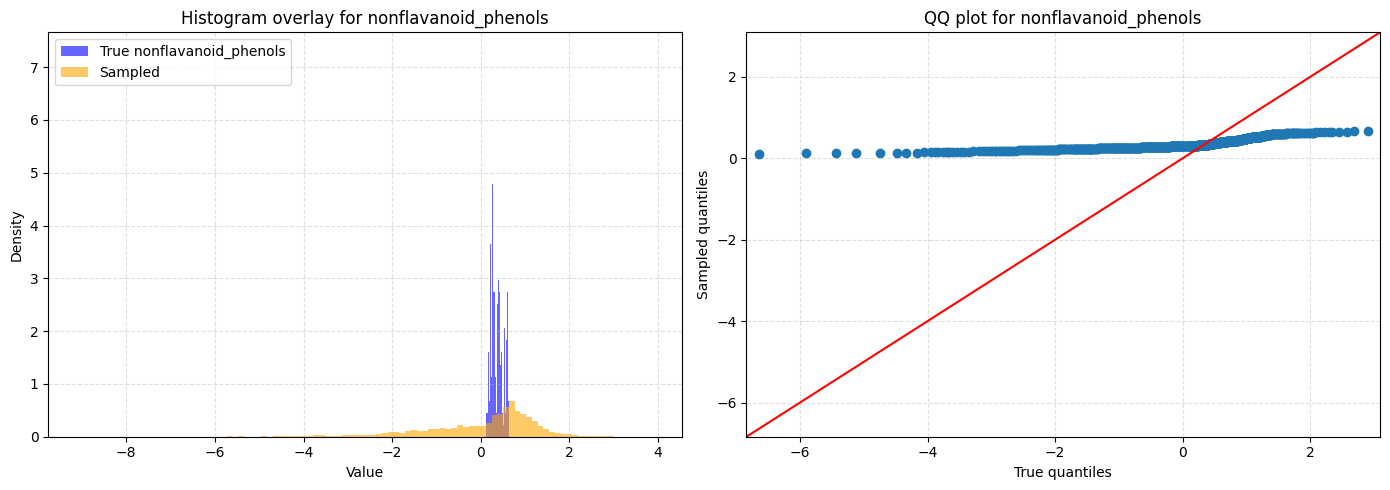

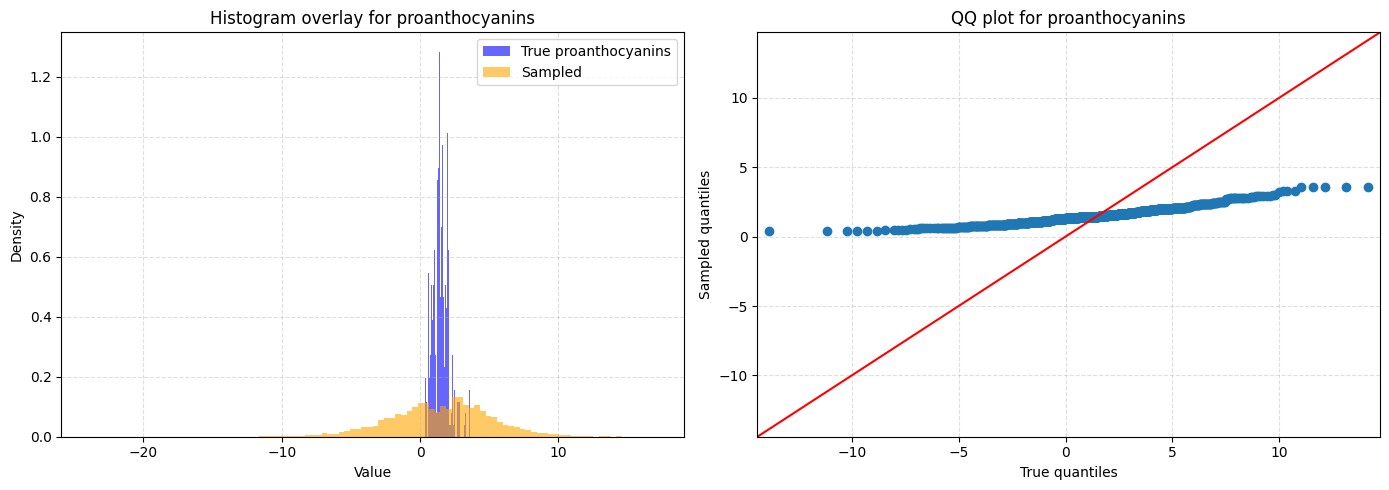

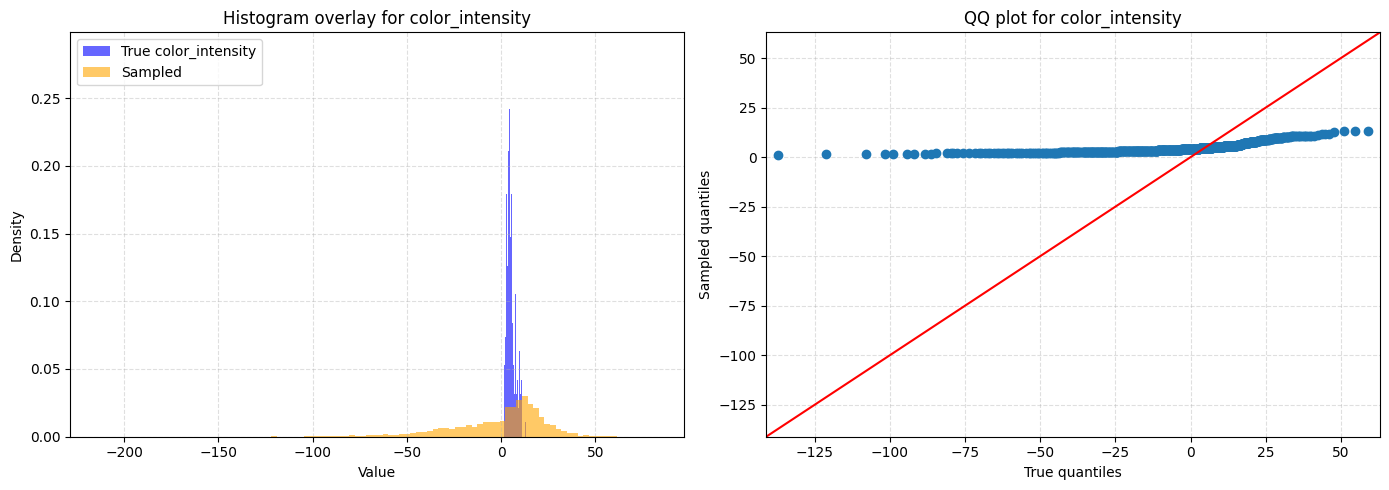

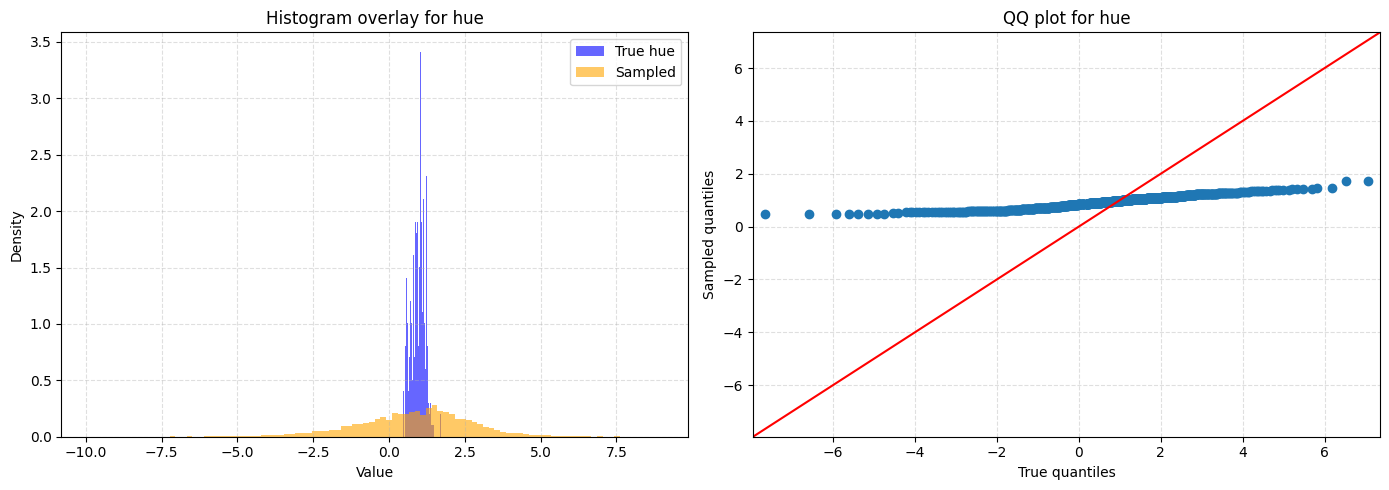

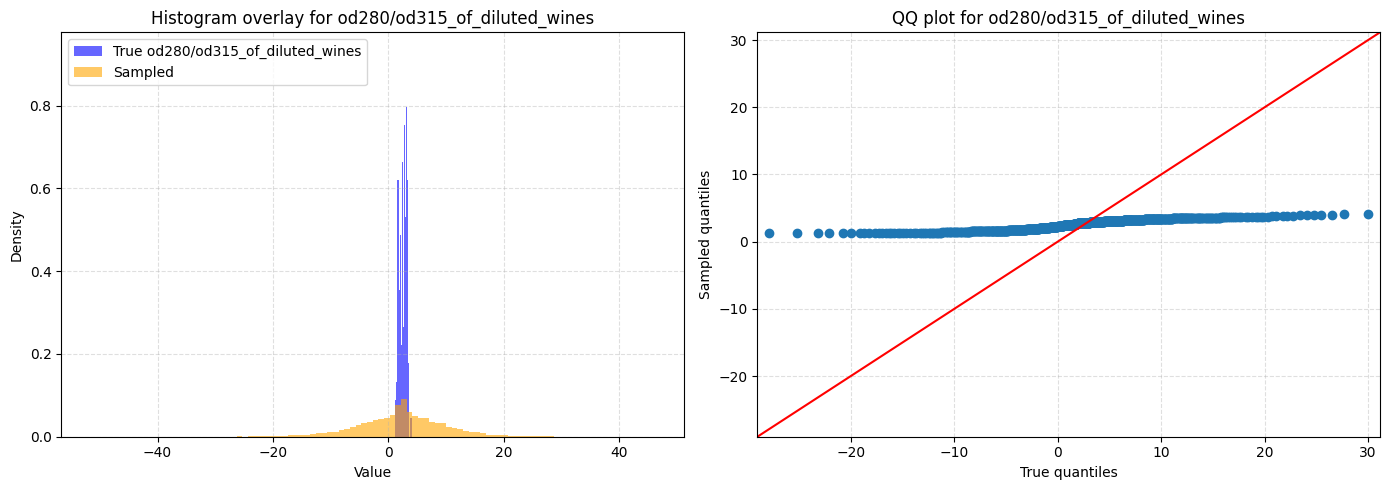

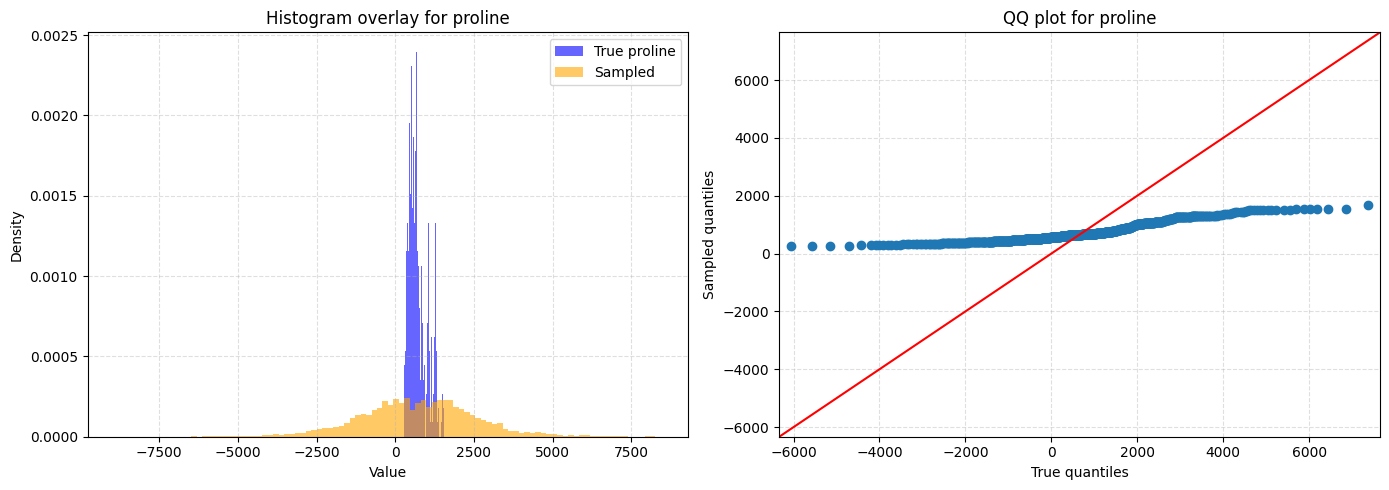

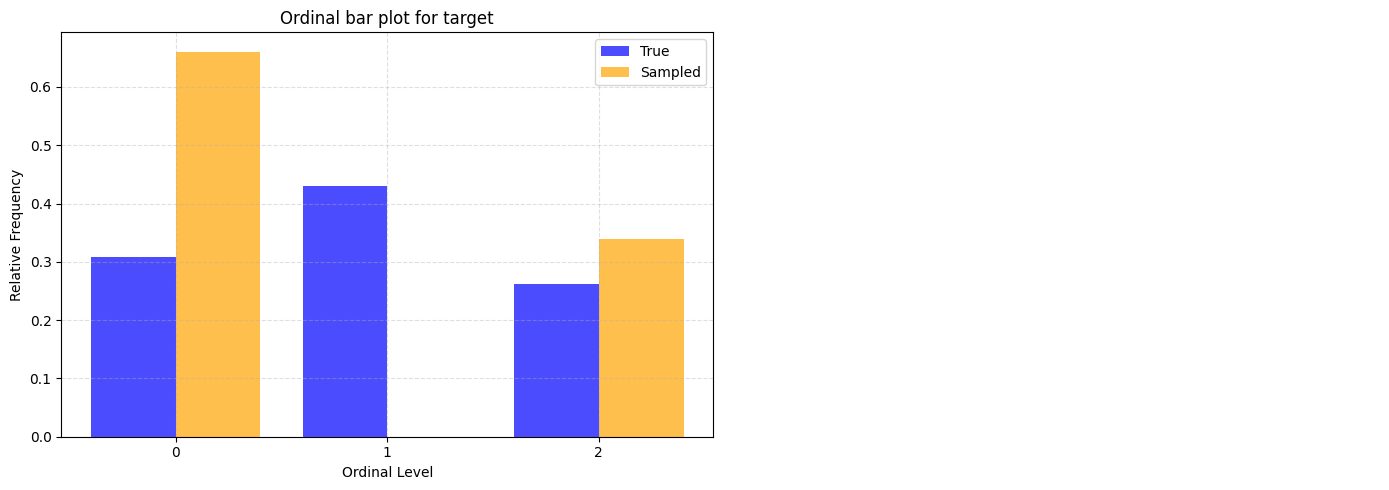

In [22]:
td_model.plot_samples_vs_true(train_df)